In [75]:
# Prepare input data
import ast
import pandas as pd
import numpy as np
from math import isnan
from collections import Counter
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import box
from sklearn.model_selection import train_test_split
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine


# set print options
np.set_printoptions(linewidth=110)
pd.set_option('display.width', 200)
plt.style.use('bmh')  # better for plotting geometries vs general plots.

# Import only first 1000 lines for testing
df = pd.read_csv('./data/sensor_readings_timeseries_part2.csv', nrows=500, parse_dates=["Timestamp"])
df = df.drop(
    ["Metadata.Location.type", "Metadata.SensorCommunitySensorType", "Metadata.SensorType", "_id"], axis=1)

# Convert string coordinates to list
df["Metadata.Location.coordinates"] = df["Metadata.Location.coordinates"].apply(
    lambda x: ast.literal_eval(x))

# no preprocessing needed
sensor_community_df = df.loc[df["Metadata.Provider"] == "sensor.community"].drop(
    ["Metadata.Provider", "Metadata.NetatmoSensorId"], axis=1)

# need to combine multiple entries for the same sensor id and time
netatmo_df = df.loc[df["Metadata.Provider"] == "netatmo"].drop(
    ["Metadata.Provider"], axis=1)

# get unique groups
grouped = netatmo_df.groupby(
    ["Metadata.NetatmoSensorId", "Timestamp"]).aggregate(list)

combined_rows = []
for label, group in grouped.iterrows():
    humidity = next((x for x in group.values[0] if not isnan(x)), np.NaN)
    pressure = next((x for x in group.values[2] if not isnan(x)), np.NaN)
    temperature = next((x for x in group.values[3] if not isnan(x)), np.NaN)

    # Humidity, Metadata.Location.coordinates, Pressure, Temperature, Timestamp
    entry = [humidity, group.values[1][0], pressure, temperature, label[1]]
    combined_rows.append(entry)

netatmo_df = pd.DataFrame(combined_rows, columns=[
                          "Humidity", "Metadata.Location.coordinates", "Pressure", "Temperature", "Timestamp"])

# Combine prepared data
prep = pd.concat([sensor_community_df, netatmo_df], ignore_index=True, axis=0)
prep = prep[prep["Temperature"].notna()]

coordinates = prep["Metadata.Location.coordinates"]
proj_wgs = 4326

geo_df = gpd.GeoDataFrame(prep[["Humidity", "Pressure", "Temperature", "Timestamp"]],
                          geometry=prep["Metadata.Location.coordinates"].apply(lambda row: Point(row[0], row[1])), crs=proj_wgs)


Text(0.5, 1.0, 'Temperature in Hamburg')

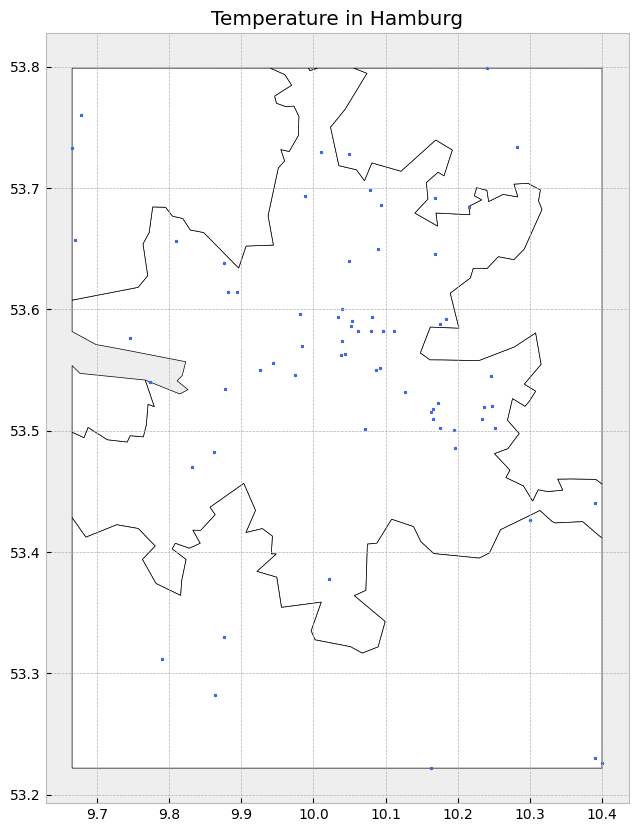

In [73]:
# Plot data
from geopandas.tools import sjoin

# Hamburg boundaries
# hamburg = gpd.read_file('./data/hamburg.shx')
# hamburg = hamburg.to_crs(proj_wgs)

# hamburg = hamburg.clip_by_rect(geo_df.total_bounds[0], geo_df.total_bounds[1], geo_df.total_bounds[2], geo_df.total_bounds[3])

# basisview = gpd.read_file(
#     './data/basisviews_bdlm_HH_EPSG_4326_2023-04-25.gpkg')
# basisview = basisview.to_crs(proj_wgs)

# basisview = basisview.clip_by_rect(geo_df.total_bounds[0], geo_df.total_bounds[1], geo_df.total_bounds[2], geo_df.total_bounds[3])

ge5000 = gpd.read_file(
    './data/ge5000.utm32s.shape/ge5000/vrm/VRM5000.shp')
ge5000 = ge5000.to_crs(proj_wgs)

ge5000 = ge5000.clip_by_rect(geo_df.total_bounds[0], geo_df.total_bounds[1], geo_df.total_bounds[2], geo_df.total_bounds[3])


# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.style.use('bmh')

ge5000.plot(ax=ax, color='white', edgecolor='black')
# hamburg.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, marker='o', color='royalblue', markersize=3)


ax.set_title('Temperature in Hamburg')


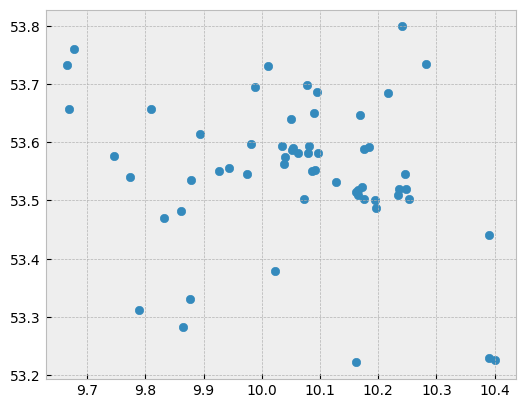

In [4]:
# Create test dataset
from pytz import UTC

start_time = pd.to_datetime('2023-02-02T20:00:00.000000000').tz_localize(UTC)
end_time = pd.to_datetime('2023-02-02T20:05:00.000000000').tz_localize(UTC)
filtered_gdf = geo_df.loc[(geo_df['Timestamp'] >= start_time)
                          & (geo_df['Timestamp'] <= end_time)]

filtered_gdf.plot()

def to_numpy_list(geo_series):
    return [[point.x, point.y]
            for point in geo_series.to_numpy()]

def geo_df_to_train_test_sets(gdf: gpd.GeoDataFrame) :
    coords_train, coords_test, value_train, value_test = train_test_split(
        filtered_gdf.geometry, filtered_gdf.Temperature, test_size=0.2, random_state=0)
    
    coords_train = to_numpy_list(coords_train)
    coords_test = to_numpy_list(coords_test)

    return coords_train, coords_test, value_train, value_test

coords_geo_train, coords_geo_test, value_geo_train, value_geo_test = geo_df_to_train_test_sets(filtered_gdf)
# Add cross validation
# print(coords_geo_train)
# print(coords_geo_train)
# print(value_geo_train)
# print(value_geo_train)


In [52]:
from sklearn import neighbors

n_neighbors = 5

knn_regressor = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')


# Fit regressor to data
knn_regressor.fit(coords_geo_train, value_geo_train)

# Generate out-of-sample R^2
out_r_squared_knn = knn_regressor.score(coords_geo_test, value_geo_test)
print("KNN out-of-sample r-squared: {}".format(round(out_r_squared_knn, 2)))

# Predict values for testing dataset
coords_rain_test_predict_knn = knn_regressor.predict(coords_geo_test)

# Create dictionary holding the actual and predicted values
predict_dict_knn = {"Coordinate_Pair": coords_geo_test,
                    "VALUE_Actual": value_geo_test, "VALUE_Predict": coords_rain_test_predict_knn}

# Create dataframe from dictionary
predict_df_knn = pd.DataFrame(predict_dict_knn)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - KNN Method")
display(predict_df_knn.head(10))


KNN out-of-sample r-squared: -1.92

Attribute Table: Testing Set Interpolated Values - KNN Method


,Coordinate_Pair,VALUE_Actual,VALUE_Predict
186,"[10.08, 53.582]",7.98,7.084931
261,"[10.184, 53.592]",4.55,5.466880
315,"[9.9886339555, 53.6937804]",5.40,4.748864
197,"[10.022, 53.378]",5.35,6.682210
74,"[10.04, 53.574]",5.24,7.011791
16,"[9.894, 53.614]",4.70,6.043133
244,"[10.096, 53.582]",5.11,7.084937
344,"[9.746, 53.576]",4.22,6.162308
297,"[9.774, 53.54]",4.96,5.782469
162,"[9.862, 53.482]",3.92,6.862244


In [76]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(
        min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode="w",
            driver="GTiff",
            height=Z.shape[0],
            width=Z.shape[1],
            count=1,
            dtype=Z.dtype,
            crs=proj,
            transform=transform,
    ) as new_dataset:
        new_dataset.write(Z, 1)

In [81]:
# Reference Krigin interpolation
# see: https://pygis.io/docs/e_interpolation.html#kriging
from pykrige.ok import OrdinaryKriging

# Set projection to WGS 84 and reproject data
krigin_gdf = filtered_gdf.to_crs(epsg=proj_wgs)

coords_ok_train, coords_ok_test, value_ok_train, value_ok_test = geo_df_to_train_test_sets(
    krigin_gdf)

# Get outer bounds for data points
minx, miny, maxx, maxy = krigin_gdf.total_bounds

# Create a 100 by 100 grid from the outer bounds
grid_lon = np.linspace(minx, maxx, 100)
grid_lat = np.linspace(miny, maxy, 100)

# Generate ordinary krigin object
OK = OrdinaryKriging(
    [item[0] for item in coords_ok_train],
    [item[1] for item in coords_ok_train],
    value_ok_train,
    variogram_model="linear",
    verbose=False,
    enable_plotting=False,
    coordinates_type="euclidean",
)

# Evaluate the method on grid
Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", grid_lon, grid_lat)

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = grid_lon, YY = grid_lat, min_x = minx, max_x = maxx, min_y = miny, max_y = maxy, proj = proj_wgs, filename = './data/hamburg_temperature_krigin.tif')

# Open raster
raster_krigin = rasterio.open('./data/hamburg_temperature_krigin.tif')

print(raster_krigin)

# Create polygon with extend of raster
poly_shapely = box(*raster_krigin.bounds)


<open DatasetReader name='./data/hamburg_temperature_krigin.tif' mode='r'>
